<a href="https://colab.research.google.com/github/JonFillip/plant_phenotyping_model/blob/main/plant_phenotype_prototype_torchvision_maskrcnn50FPN_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
!pip install torch torchvision cython
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip install opencv-python
!pip install fvcore


In [ ]:
!git clone https://github.com/pytorch/vision.git

In [ ]:
%cd vision
!pip install -e .

In [ ]:
!pip install --upgrade pillow

In [ ]:
!pip install piexif

In [1]:
from pathlib import Path
import albumentations as A
import cv2
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import xml.etree.ElementTree as ET
import seaborn as sns
import random
import os
import glob
import json
import random
import warnings
import skimage.draw
import pprint
from skimage import measure
from PIL import Image, ImageOps, ExifTags
from matplotlib.lines import Line2D
from google.colab.patches import cv2_imshow
from google.colab import drive, files
import matplotlib.patches as patches
import piexif
from tqdm import tqdm
from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold
import matplotlib.pyplot as plt
import time
import math
import sys

# PyTorch related libraries
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.models.detection
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.io import read_image
from pycocotools.mask import decode, frPyObjects
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from vision.references.detection import utils
from vision.references.detection.coco_utils import get_coco_api_from_dataset
from vision.references.detection.coco_eval import CocoEvaluator
from torchvision.utils import draw_segmentation_masks, draw_bounding_boxes
import torchvision.transforms.functional as F
from torchvision.transforms.functional import resize
from torchvision.models.detection import maskrcnn_resnet50_fpn
import torch.nn.functional as N
from torchvision.ops import box_iou
from albumentations.pytorch import ToTensorV2
from albumentations.augmentations.geometric.rotate import Rotate
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights, MaskRCNN_ResNet50_FPN_V2_Weights, maskrcnn_resnet50_fpn_v2

In [2]:
pp = pprint.PrettyPrinter(indent=4)
print(torchvision.__version__)

%matplotlib inline

0.16.0a0+8faa1b1


In [3]:
warnings.filterwarnings('ignore')

In [4]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:

PATH = "/content/drive/My Drive/Colab Notebooks/plant_phenotyping_bigdata/"

# Function checks if data directory exists and changes to that directory if so
def fetch_phenotype_data(path=PATH):
  if os.path.exists(PATH):
    print('directory already exists')
  else:
    os.makedirs(PATH)
    upload = files.upload()

  # change directory to 'plant_phenotyping_bigdata'
  %cd /content/drive/My Drive/Colab Notebooks/plant_phenotyping_bigdata/


fetch_phenotype_data()

directory already exists
/content/drive/My Drive/Colab Notebooks/plant_phenotyping_bigdata


# image_load_and_preprocessing

In [ ]:

class CustomImageDataset(Dataset):
    def __init__(self, img_dir):
        self.img_dir = img_dir
        self.img_paths = glob.glob(os.path.join(img_dir, '*.jpg'))
        self.transform = transforms.Compose([
            transforms.Resize((800, 800)),
            transforms.ToTensor(),
        ])

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path)
        img = img.convert('RGB')

        # Correct image orientation
        try:
            img = ImageOps.exif_transpose(img)
        except:
            pass

        img = self.transform(img)
        img_filename = os.path.splitext(os.path.basename(img_path))[0]  # Get filename without extension
        return img, img_filename

    def __len__(self):
        return len(self.img_paths)


In [ ]:
#@title

laboro_train_path = os.path.join(PATH, 'laboro_tomato', 'train')
laboro_test_path = os.path.join(PATH, 'laboro_tomato', 'test')

laboro_train = CustomImageDataset(laboro_train_path)
laboro_test = CustomImageDataset(laboro_test_path)

In [ ]:
print(f"number of laboro train images: {len(laboro_train)}")
print(f"number of laboro test images: {len(laboro_test)}")


number of laboro train images: 643
number of laboro test images: 161


# Load Images and Annotations in PyTorch Datasets

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, annotations_file):
        super(CustomImageDataset, self).__init__()
        self.img_dir = img_dir
        self.annotations = json.load(open(annotations_file, 'r'))

        self.cat2label = {cat['id']: i for i, cat in enumerate(self.annotations['categories'], start=1)}

        self.images = {img['id']: img for img in self.annotations['images']}

        self.annotations_map = {}
        for ann in self.annotations['annotations']:
            image_id = ann['image_id']
            if image_id not in self.annotations_map:
                self.annotations_map[image_id] = []
            self.annotations_map[image_id].append(ann)
        self.image_ids = list(self.annotations_map.keys())


    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.images[img_id]
        img_path = os.path.join(self.img_dir, img_info['file_name'])

        img = Image.open(img_path).convert('RGB')

        try:
            img = ImageOps.exif_transpose(img)
        except:
            pass

        min_size = 800
        max_size = 1333

        width, height = img.size
        scale = min_size / min(width, height)
        if max(width, height) * scale > max_size:
            scale = max_size / max(width, height)

        new_width = int(width * scale)
        new_height = int(height * scale)

        img = transforms.functional.resize(img, (new_height, new_width))
        img = transforms.functional.to_tensor(img)
        img = transforms.functional.normalize(img, (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

        annotations = self.annotations_map[img_id]

        boxes = []
        maturity_labels = []
        masks = []
        areas = []
        iscrowd = []
        for ann in annotations:
            bbox = ann['bbox']
            bbox = [
                bbox[0] * scale,
                bbox[1] * scale,
                (bbox[0] + bbox[2]) * scale,
                (bbox[1] + bbox[3]) * scale,
            ]

            # Ignore boxes with zero area
            if bbox[2] - bbox[0] <= 0 or bbox[3] - bbox[1] <= 0:
                continue

            boxes.append(bbox)
            maturity_labels.append(self.cat2label[ann['category_id']])

            segmentation = ann['segmentation']
            mask = decode(frPyObjects(segmentation, height, width))
            mask = mask.squeeze()

            # Convert mask to Image for resizing
            mask_img = Image.fromarray(mask.astype(np.uint8) * 255)  # For visualization purposes, scale to [0, 255]
            mask_img = mask_img.resize((new_width, new_height), Image.NEAREST)

            # Convert the resized mask back to numpy and normalize to [0, 1]
            mask = np.array(mask_img).astype(np.float32) / 255.0  # Convert to float32 and scale back to [0, 1]

            masks.append(mask)


            areas.append(ann['area'] * scale * scale)  # scale the area according to the image scaling
            iscrowd.append(ann['iscrowd'])

        if len(boxes) == 0:
            target = {
                "boxes": torch.zeros((0, 4), dtype=torch.float32),
                "labels": torch.zeros(0, dtype=torch.int64),
                "masks": torch.zeros((0, 800, 800), dtype=torch.uint8),
                "image_id": torch.tensor([img_id]),
                "area": torch.zeros(0, dtype=torch.float32),
                "iscrowd": torch.zeros(0, dtype=torch.int64)
            }
            return img, target

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        maturity_labels = torch.as_tensor(maturity_labels, dtype=torch.int64)
        masks = torch.stack([torch.as_tensor(mask, dtype=torch.uint8) for mask in masks])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = maturity_labels
        target["masks"] = masks
        target["image_id"] = torch.tensor([img_id])
        target["area"] = areas
        target["iscrowd"] = iscrowd

        assert not torch.isnan(img).any(), f'NaN value found in image for idx: {idx}'
        assert not torch.isnan(target["boxes"]).any(), f'NaN value found in boxes for idx: {idx}'
        assert not torch.isnan(target["labels"]).any(), f'NaN value found in maturity_labels for idx: {idx}'
        assert not torch.isnan(target["masks"]).any(), f'NaN value found in masks for idx: {idx}'
        assert not torch.isnan(target["area"]).any(), f'NaN value found in area for idx: {idx}'
        assert not torch.isnan(target["iscrowd"]).any(), f'NaN value found in iscrowd for idx: {idx}'

        return img, target

    def __len__(self):
        return len(self.image_ids)

    def get_maturity(self, cat_id):
        return self.cat2label[cat_id]

    def get_image_id(self, idx):
        return self.image_ids[idx]


In [7]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [8]:
laboro_train_path = os.path.join(PATH, 'laboro_tomato', 'train')
laboro_test_path = os.path.join(PATH, 'laboro_tomato', 'test')
laboro_train_ann_path = PATH + 'laboro_tomato/annotations/train.json'
laboro_test_ann_path = PATH + 'laboro_tomato/annotations/test.json'

In [9]:
laboro_train_dataset = CustomImageDataset(laboro_train_path, laboro_train_ann_path)
laboro_test_dataset = CustomImageDataset(laboro_test_path, laboro_test_ann_path)

In [10]:
laboro_train_data_loader = DataLoader(
    laboro_train_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

laboro_test_data_loader = DataLoader(
    laboro_test_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

# To verify if the records have been loaded and processed. Also visualize the images with their mask layered over the image

In [11]:
# Get a batch of training data
images, targets = next(iter(laboro_train_data_loader))

print(f"Number of images in the batch: {len(images)}")
total_labels = sum(len(target['labels']) for target in targets)
print(f"Number of labels in the batch: {total_labels}")

# For each image-target pair in the batch
for i in range(len(images)):
    print(f"\nImage {i+1}:")

    # Print image shape
    print(f"Image shape: {images[i].shape}")

    # Extract the target
    target = targets[i]

    # Print details of the target
    boxes = target['boxes']
    maturity_labels = target['labels']
    masks = target['masks']
    image_id = target['image_id']
    areas = target['area']
    iscrowd = target['iscrowd']

    print(f"Boxes shape: {boxes.shape}")
    print(f"Maturity labels shape: {maturity_labels.shape}")
    print(f"Masks shape: {masks.shape}")
    print(f'Area shape: {areas.shape}')
    print(f'IsCrowd shape: {iscrowd.shape}')
    print(f"Image ID: {image_id}")


Number of images in the batch: 1
Number of labels in the batch: 14

Image 1:
Image shape: torch.Size([3, 1066, 800])
Boxes shape: torch.Size([14, 4])
Maturity labels shape: torch.Size([14])
Masks shape: torch.Size([14, 1066, 800])
Area shape: torch.Size([14])
IsCrowd shape: torch.Size([14])
Image ID: tensor([335])


In [12]:
def visualize_image_and_mask(images, targets, image_idx=0):
    # de-normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = images[image_idx].permute(1, 2, 0).numpy()
    image = std * image + mean
    image = np.clip(image, 0, 1) # Clip to range [0,1] if any values are out of this range due to floating point errors

    boxes = targets[image_idx]['boxes']
    masks = targets[image_idx]['masks']
    maturity_labels = targets[image_idx]['labels']
    image_id = targets[image_idx]['image_id']

    fig, ax = plt.subplots(1, 1, figsize=(12, 9))

    # Display the image
    ax.imshow(image)

    # Create a Rectangle patch for each mask
    for i in range(masks.shape[0]):
        mask = masks[i].numpy().squeeze()  # Use squeeze() to remove singleton dimensions
        maturity_label = maturity_labels[i].item()

        # Create a color for each label
        cmap = plt.get_cmap("tab20b")
        colors = [cmap(i) for i in np.linspace(0, 1, 20)]
        color = colors[np.random.randint(len(colors))] # Random color for each instance

        # Draw bbox
        box = boxes[i]
        rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

        # Find contour from the binary mask
        contours = measure.find_contours(mask, 0.5)

        # Display the mask with its contour
        for contour in contours:
            ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color=color)
            ax.fill(contour[:, 1], contour[:, 0], color=color, alpha=0.4)

    plt.title(f"Image ID: {image_id.item()}")
    plt.show()

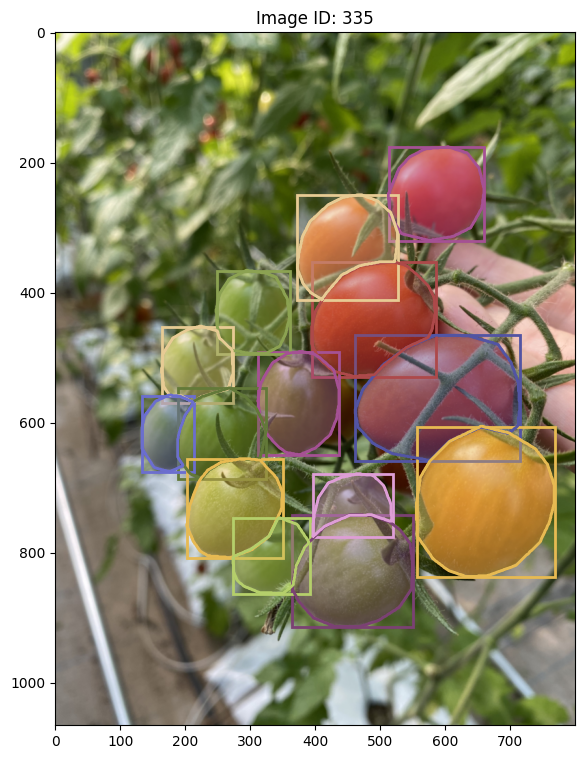

In [13]:
visualize_image_and_mask(images, targets, image_idx=0)


# Train model


### Stage 1: Train Object detection Mask R-CNN

In [ ]:
# Prepare the train-validation division
train_size = int(0.8 * len(laboro_train_dataset))
val_size = len(laboro_train_dataset) - train_size
torch.manual_seed(0)
train_dataset, val_dataset = torch.utils.data.random_split(laboro_train_dataset, [train_size, val_size])
assert len(train_dataset) + len(val_dataset) == len(laboro_train_dataset)



In [ ]:
sample = val_dataset.dataset[0]
print(sample)


(tensor([[[-0.6109, -0.6281, -0.5424,  ...,  1.4954,  1.5125,  1.4098],
         [-0.5938, -0.6109, -0.6281,  ...,  1.7009,  1.4269,  1.3413],
         [-0.6109, -0.6794, -0.7479,  ...,  1.9920,  1.5297,  1.3755],
         ...,
         [-0.8849, -0.9705, -1.1418,  ..., -0.8507, -0.8507, -0.9363],
         [-0.8849, -0.9534, -1.0562,  ..., -0.8507, -0.8507, -0.8678],
         [-0.9363, -0.9363, -0.9534,  ..., -0.7993, -0.7650, -0.7650]],

        [[ 0.0126, -0.0224,  0.0301,  ...,  1.9909,  1.9909,  1.9384],
         [ 0.0301, -0.0049, -0.0224,  ...,  2.1485,  1.9384,  1.8859],
         [ 0.0126, -0.0399, -0.1099,  ...,  2.3235,  1.9909,  1.8508],
         ...,
         [-0.4601, -0.5826, -0.7227,  ..., -0.2850, -0.2500, -0.3025],
         [-0.4601, -0.5476, -0.6527,  ..., -0.2850, -0.2675, -0.2500],
         [-0.5301, -0.5476, -0.5651,  ..., -0.2325, -0.2500, -0.2500]],

        [[-0.7761, -0.8110, -0.7413,  ..., -1.1421, -1.0550, -1.3513],
         [-0.7413, -0.7761, -0.7761,  ..., -

In [ ]:
# Get the indices of the train and validation dataset
val_indices = val_dataset.indices
train_indices = train_dataset.indices

# Fetch the image IDs using these indices
val_image_ids = [val_dataset.dataset[i][1]['image_id'].item() for i in val_indices]


In [ ]:
coco = COCO(laboro_train_ann_path)  # Load COCO annotation file
coco_image_ids = set(coco.getImgIds())


loading annotations into memory...
Done (t=0.10s)
creating index...
index created!


In [ ]:
val_image_ids_set = set(val_image_ids)

missing_in_val = coco_image_ids - val_image_ids_set
extra_in_val = val_image_ids_set - coco_image_ids

if missing_in_val:
    print(f"IDs missing in val_dataset: {missing_in_val}")
    print(f"Lenght of missing val indices: {len(missing_in_val)}")

if extra_in_val:
    print(f"Extra IDs in val_dataset: {extra_in_val}")


IDs missing in val_dataset: {0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 22, 23, 25, 27, 28, 29, 32, 33, 34, 35, 36, 37, 39, 40, 41, 43, 44, 45, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 117, 119, 120, 122, 123, 124, 125, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 140, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 163, 164, 165, 166, 168, 169, 170, 171, 172, 173, 174, 175, 176, 178, 180, 182, 183, 184, 185, 187, 188, 189, 191, 192, 193, 194, 197, 199, 200, 201, 203, 204, 205, 206, 207, 208, 209, 210, 212, 213, 214, 215, 216, 217, 218, 219, 220, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 236, 238, 240, 241, 242, 243, 244, 246, 247, 248, 250, 251, 252, 253, 254, 

In [ ]:
train_image_ids_set = set([train_dataset.dataset[i][1]['image_id'].item() for i in train_indices])

missing_in_train = coco_image_ids - train_image_ids_set
extra_in_train = train_image_ids_set - coco_image_ids

if missing_in_train:
    print(f"IDs missing in train_dataset: {missing_in_train}")
    print(f"Lenght of missing train indices: {len(missing_in_train)}")

if extra_in_train:
    print(f"Extra IDs in train_dataset: {extra_in_train}")


IDs missing in train_dataset: {512, 2, 518, 14, 15, 532, 21, 535, 24, 26, 541, 30, 31, 544, 549, 38, 550, 552, 42, 46, 47, 559, 51, 574, 577, 67, 68, 579, 581, 586, 587, 588, 589, 590, 599, 601, 610, 612, 101, 102, 614, 615, 618, 622, 623, 114, 118, 121, 634, 635, 636, 126, 638, 641, 642, 139, 141, 161, 162, 167, 177, 179, 181, 186, 190, 195, 196, 198, 202, 211, 221, 235, 237, 239, 245, 249, 256, 258, 264, 266, 295, 300, 303, 305, 309, 310, 320, 326, 329, 331, 334, 335, 339, 341, 346, 359, 362, 372, 392, 396, 403, 407, 415, 416, 422, 424, 428, 429, 439, 441, 444, 446, 448, 451, 458, 462, 466, 469, 471, 472, 476, 477, 478, 492, 493, 494, 501, 503, 508}
Lenght of missing train indices: 129


In [ ]:
if missing_in_train == val_image_ids_set:
    print("The missing train IDs are the same as the val IDs. The split is correct!")
else:
    print("There's a discrepancy between the missing train IDs and the val IDs.")


The missing train IDs are the same as the val IDs. The split is correct!


In [17]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq, scaler=None):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Epoch: [{epoch}]"

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger

def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types




@torch.inference_mode()
@torch.no_grad()
def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = "Test:"

    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for images, targets in metric_logger.log_every(data_loader, 100, header):
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        if torch.cuda.is_available():
            torch.cuda.synchronize()
        model_time = time.time()
        output_dicts = model(images)

        output_dicts = [{k: v.to(cpu_device) for k, v in t.items()} for t in output_dicts]
        model_time = time.time() - model_time

        res = {target["image_id"].item(): output for target, output in zip(targets, output_dicts)}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

        # Calculate and log losses
        if targets is not None:
            # Switch to training mode to compute the losses
            model.train()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            # Switch back to eval mode
            model.eval()
            # Update logger
            metric_logger.update(loss=losses, **loss_dict)

    metric_logger.synchronize_between_processes()
    coco_evaluator.synchronize_between_processes()

    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)
    return metric_logger, coco_evaluator


In [ ]:
def plot_losses(metrics):
    epochs = range(1, len(metrics['train_loss']) + 1)

    fig, axs = plt.subplots(3, 3, figsize=(15,10))

    # Total loss
    axs[0, 0].plot(epochs, metrics['train_loss'], 'r', label='Train Loss')
    axs[0, 0].plot(epochs, metrics['val_loss'], 'b', label='Val Loss')
    axs[0, 0].legend()
    axs[0, 0].set_title('Total Loss')

    # Box loss
    axs[0, 1].plot(epochs, metrics['train_loss_box_reg'], 'r', label='Train Box Loss')
    axs[0, 1].plot(epochs, metrics['val_loss_box_reg'], 'b', label='Val Box Loss')
    axs[0, 1].legend()
    axs[0, 1].set_title('Box Loss')

    # Mask loss
    axs[0, 2].plot(epochs, metrics['train_loss_mask'], 'r', label='Train Mask Loss')
    axs[0, 2].plot(epochs, metrics['val_loss_mask'], 'b', label='Val Mask Loss')
    axs[0, 2].legend()
    axs[0, 2].set_title('Mask Loss')

    # Objectness loss
    axs[1, 0].plot(epochs, metrics['train_loss_objectness'], 'r', label='Train Objectness Loss')
    axs[1, 0].plot(epochs, metrics['val_loss_objectness'], 'b', label='Val Objectness Loss')
    axs[1, 0].legend()
    axs[1, 0].set_title('Objectness Loss')

    # RPN box loss
    axs[1, 1].plot(epochs, metrics['train_loss_rpn_box_reg'], 'r', label='Train RPN Box Loss')
    axs[1, 1].plot(epochs, metrics['val_loss_rpn_box_reg'], 'b', label='Val RPN Box Loss')
    axs[1, 1].legend()
    axs[1, 1].set_title('RPN Box Loss')

    # Learning Rate
    axs[1, 2].plot(epochs, metrics['lr'], 'r', label='Learning Rate')
    axs[1, 2].legend()
    axs[1, 2].set_title('Learning Rate')

    plt.tight_layout()
    plt.show()

Epoch: [0]  [ 0/33]  eta: 0:10:13  lr: 0.000001  loss: 4.9591 (4.9591)  loss_classifier: 1.8281 (1.8281)  loss_box_reg: 0.3944 (0.3944)  loss_mask: 2.3884 (2.3884)  loss_objectness: 0.3061 (0.3061)  loss_rpn_box_reg: 0.0421 (0.0421)  time: 18.5870  data: 17.7942  max mem: 22401
Epoch: [0]  [10/33]  eta: 0:07:54  lr: 0.000014  loss: 4.0127 (3.9569)  loss_classifier: 1.5398 (1.4481)  loss_box_reg: 0.4206 (0.4393)  loss_mask: 1.7937 (1.7656)  loss_objectness: 0.2574 (0.2575)  loss_rpn_box_reg: 0.0421 (0.0463)  time: 20.6423  data: 19.9245  max mem: 22401
Epoch: [0]  [20/33]  eta: 0:04:33  lr: 0.000026  loss: 2.5491 (3.0989)  loss_classifier: 0.8378 (1.0651)  loss_box_reg: 0.4136 (0.4333)  loss_mask: 1.1265 (1.3279)  loss_objectness: 0.2038 (0.2262)  loss_rpn_box_reg: 0.0474 (0.0464)  time: 21.1286  data: 20.4198  max mem: 22401
Epoch: [0]  [30/33]  eta: 0:01:02  lr: 0.000039  loss: 2.0909 (2.7668)  loss_classifier: 0.6510 (0.9410)  loss_box_reg: 0.4480 (0.4610)  loss_mask: 0.6898 (1.1098)

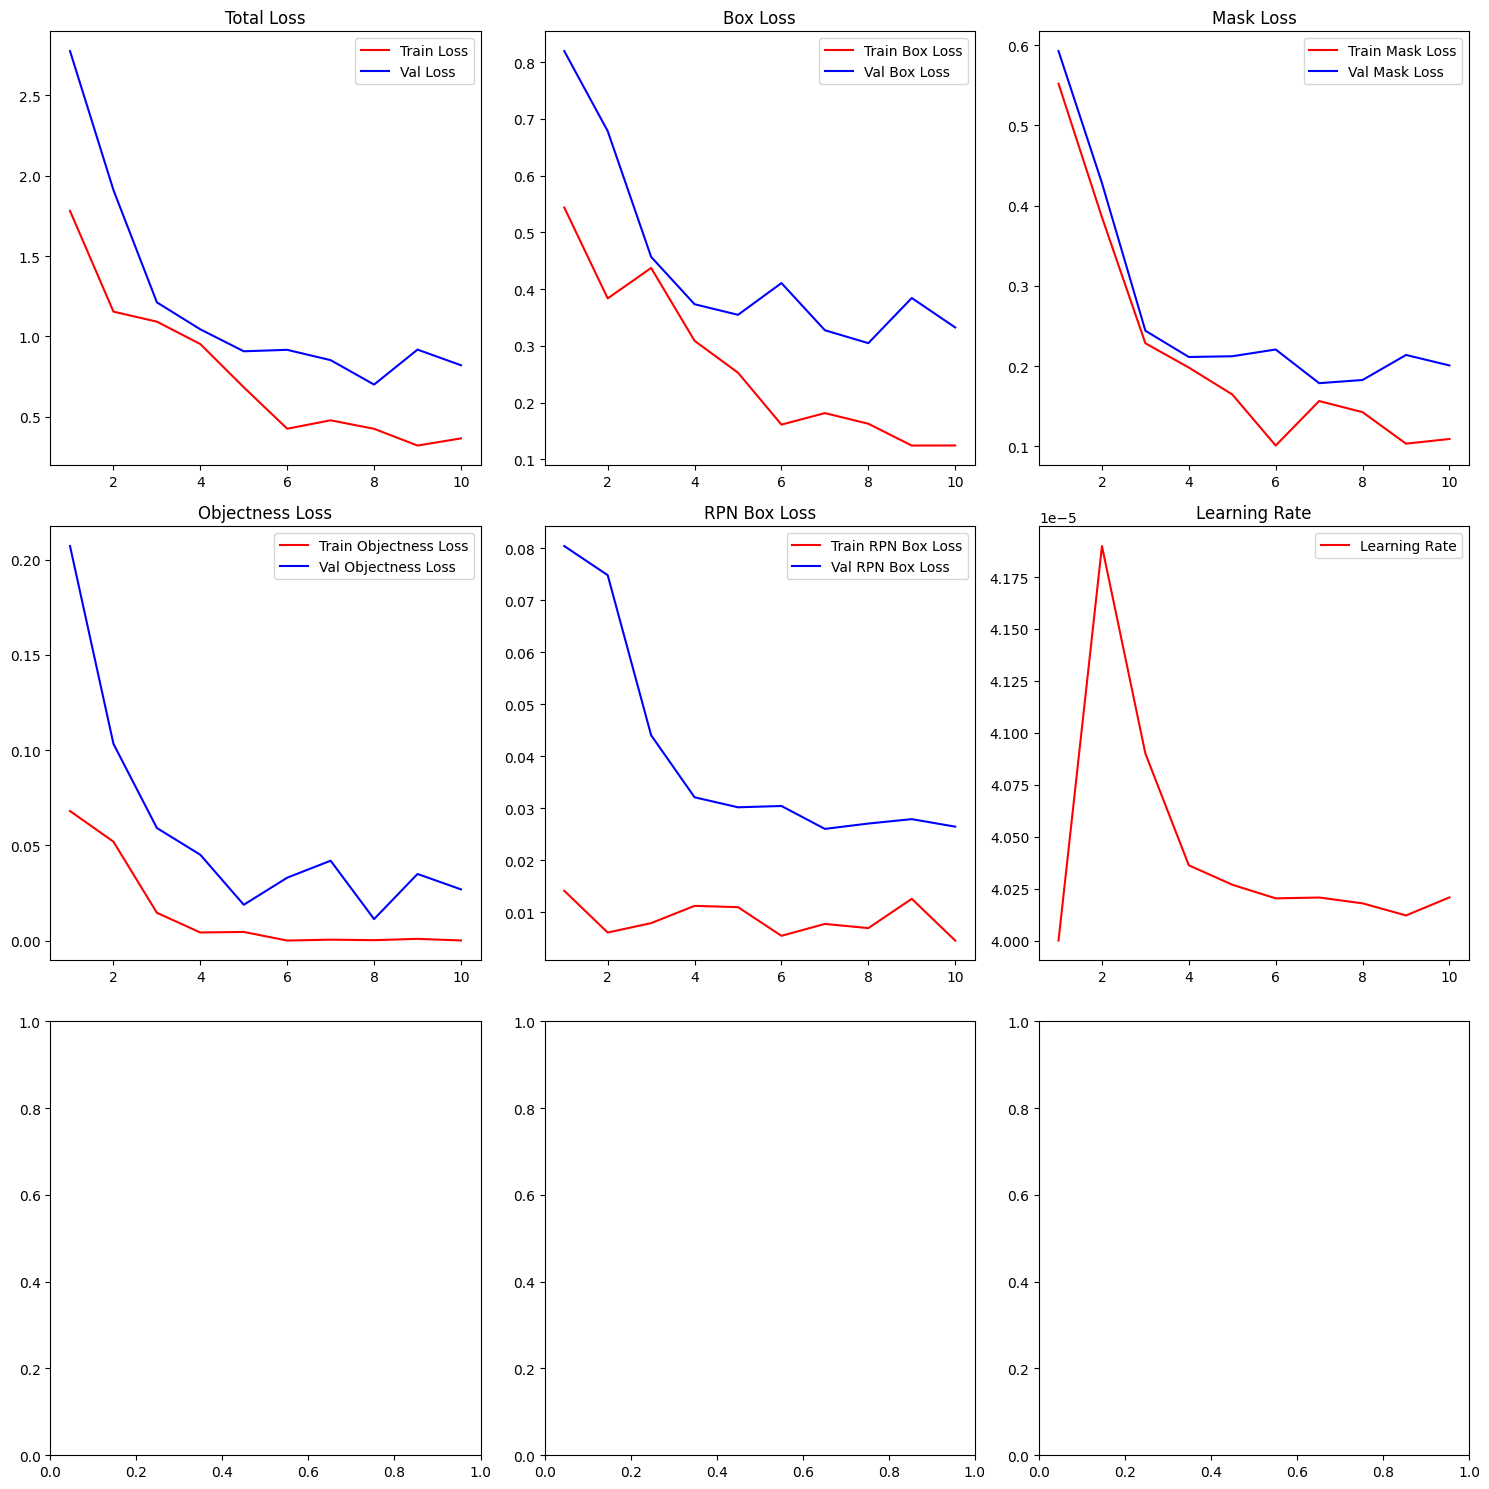

In [ ]:
# Configuration parameters
num_epochs = 10
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
n_epochs_stop = 3
tolerance = 0.2

# Initialize early stopping variables
min_val_loss = np.Inf
epochs_no_improve = 0


# Add lists to track the metrics
metrics = {
    'train_loss': [],
    'val_loss': [],
    'train_loss_box_reg': [],
    'val_loss_box_reg': [],
    'train_loss_mask': [],
    'val_loss_mask': [],
    'train_loss_objectness': [],
    'val_loss_objectness': [],
    'train_loss_rpn_box_reg': [],
    'val_loss_rpn_box_reg': [],
    'lr': [],
}

min_delta = 0.001  # minimum change in the monitored quantity to qualify as an improvement
best_val_loss = np.Inf  # to keep track of the best validation loss
best_val_loss_change = np.Inf

# Define data loaders for training and validation data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

# Initialize the Mask R-CNN model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT)
num_classes = 7  # 6 classes (maturity levels) + 1 class (background)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
model.to(device)

# Set the optimizer and scheduler
init_lr = 0.001
weight_decay = 0.0005
momentum = 0.9
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=init_lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=init_lr, steps_per_epoch=len(train_loader), epochs=num_epochs)

# Train and validate for each epoch
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    metric_logger = train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)

    # evaluate on the test dataset
    eval_logger, coco_evaluator = evaluate(model, val_loader, device)

    print(eval_logger.meters.keys())
    print(f"DEBUG: Training Metrics: {metric_logger.meters}")
    print(f"DEBUG: Evaluation Metrics: {eval_logger.meters}")

    metrics['train_loss'].append(metric_logger.meters['loss'].value)
    metrics['val_loss'].append(eval_logger.meters['loss'].value)

    metrics['train_loss_box_reg'].append(metric_logger.meters['loss_box_reg'].value)
    metrics['val_loss_box_reg'].append(eval_logger.meters['loss_box_reg'].value)

    metrics['train_loss_mask'].append(metric_logger.meters['loss_mask'].value)
    metrics['val_loss_mask'].append(eval_logger.meters['loss_mask'].value)

    metrics['train_loss_objectness'].append(metric_logger.meters['loss_objectness'].value)
    metrics['val_loss_objectness'].append(eval_logger.meters['loss_objectness'].value)

    metrics['train_loss_rpn_box_reg'].append(metric_logger.meters['loss_rpn_box_reg'].value)
    metrics['val_loss_rpn_box_reg'].append(eval_logger.meters['loss_rpn_box_reg'].value)

    metrics['lr'].append(optimizer.param_groups[0]["lr"])

    # Check for improvement and save best weights
    val_loss_change = best_val_loss - metrics['val_loss'][-1]
    if val_loss_change > min_delta:
        epochs_no_improve = 0
        best_val_loss = metrics['val_loss'][-1]
        best_val_loss_change = val_loss_change
        torch.save(model.state_dict(), f'mrcnn_rn50fpnv1_best_model_epoch{epoch}_val_loss{metrics["val_loss"][-1]:.4f}.pth')
    else:
        epochs_no_improve += 1

    if epochs_no_improve == n_epochs_stop:
        print('Early stopping!')
        break

    # update the learning rate
    if scheduler is not None:
        scheduler.step(metrics['val_loss'][-1])

# Plot the losses
plot_losses(metrics)


## Test the saved model's generalization on the test dataset

In [14]:
testset_data_loader = DataLoader(
    laboro_test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [18]:
@torch.inference_mode()
@torch.no_grad()
def evaluate_test_set(saved_model_path, data_loader, device):
    # Initialize the Mask R-CNN model
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=None)
    num_classes = 7  # 6 classes (maturity levels) + 1 class (background)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
    model.to(device)

    # Load saved weights
    model.load_state_dict(torch.load(saved_model_path))

    model.eval()

    n_threads = torch.get_num_threads()
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")

    metric_logger = utils.MetricLogger(delimiter="  ")
    header = "Test:"
    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)  # Assuming this function was defined previously or imported
    coco_evaluator = CocoEvaluator(coco, iou_types)

    all_predictions = []

    for images, targets in metric_logger.log_every(data_loader, 100, header):
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        output_dicts = model(images)
        output_dicts = [{k: v.to(cpu_device) for k, v in t.items()} for t in output_dicts]
        all_predictions.extend(output_dicts)

        res = {target["image_id"].item(): output for target, output in zip(targets, output_dicts)}
        coco_evaluator.update(res)

        # Calculate and log losses (optional, if you also want to log the losses during evaluation)
        if targets is not None:
            # Switch to training mode to compute the losses
            model.train()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            # Switch back to eval mode
            model.eval()
            # Update logger
            metric_logger.update(loss=losses, **loss_dict)

    metric_logger.synchronize_between_processes()
    coco_evaluator.synchronize_between_processes()
    coco_evaluator.accumulate()
    coco_evaluator.summarize()

    torch.set_num_threads(n_threads)
    return model, metric_logger, coco_evaluator, all_predictions

In [19]:
saved_model_path = PATH + 'mrcnn_rn50fpnv1_best_model_epoch7_val_loss0.7002.pth'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model, metric_logger, coco_evaluator, all_predictions = evaluate_test_set(saved_model_path, testset_data_loader, device)


creating index...
index created!
Test:  [ 0/11]  eta: 0:04:50  loss: 0.4036 (0.4036)  loss_classifier: 0.1273 (0.1273)  loss_box_reg: 0.1384 (0.1384)  loss_mask: 0.1184 (0.1184)  loss_objectness: 0.0144 (0.0144)  loss_rpn_box_reg: 0.0051 (0.0051)  time: 26.4184  data: 16.6464  max mem: 6970
Test:  [10/11]  eta: 0:00:08  loss: 0.7646 (0.7622)  loss_classifier: 0.2513 (0.2459)  loss_box_reg: 0.2657 (0.2484)  loss_mask: 0.1999 (0.1807)  loss_objectness: 0.0490 (0.0685)  loss_rpn_box_reg: 0.0163 (0.0187)  time: 8.7148  data: 4.9265  max mem: 9589
Test: Total time: 0:01:35 (8.7209 s / it)
Accumulating evaluation results...
DONE (t=0.17s).
Accumulating evaluation results...
DONE (t=0.16s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.549
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.769
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.644
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= 

In [66]:
def plot_single_prediction(image, target, output, confidence_threshold=0.5, image_id=None):
    # Convert tensors to numpy arrays for plotting

    mask = output[0]['scores'] > confidence_threshold
    output[0]['boxes'] = output[0]['boxes'][mask]
    output[0]['labels'] = output[0]['labels'][mask]
    output[0]['masks'] = output[0]['masks'][mask]

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_np = image.cpu().numpy().transpose((1, 2, 0)) * std + mean
    image_np = np.clip(image_np, 0, 1)

    # Plot original image, ground truth, and prediction
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    # Display the image
    title = 'Original Image' if image_id is None else f'Original Image (ID: {image_id})'
    axs[0].imshow(image_np)
    axs[0].set_title(title)

    # Display the ground truth masks with its contour
    axs[1].imshow(image_np)
    axs[1].set_title('Ground Truth')
    for mask in target['masks']:
        mask_np = mask.cpu().numpy()
        contours = measure.find_contours(mask_np, 0.5)
        color = (random.random(), random.random(), random.random())  # Random color for each mask
        for contour in contours:
            axs[1].plot(contour[:, 1], contour[:, 0], linewidth=2, color=color)
            axs[1].fill(contour[:, 1], contour[:, 0], color=color, alpha=0.4)
    for box, label in zip(target['boxes'], target['labels']):
        box = box.cpu()  # Move the tensor to CPU
        rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor='r', facecolor='none')
        axs[1].add_patch(rect)
        axs[1].text(box[0], box[1], f'Label: {label.item()}', color='r')

    # Display the predicted masks with its contour
    axs[2].imshow(image_np)
    axs[2].set_title('Prediction')
    for mask in output[0]['masks']:
        mask_np = mask[0, :, :].detach().cpu().numpy()
        contours = measure.find_contours(mask_np, 0.5)
        color = (random.random(), random.random(), random.random())  # Random color for each mask
        for contour in contours:
            axs[2].plot(contour[:, 1], contour[:, 0], linewidth=2, color=color)
            axs[2].fill(contour[:, 1], contour[:, 0], color=color, alpha=0.4)
    for box, label in zip(output[0]['boxes'], output[0]['labels']):
        box = box.cpu()  # Move the tensor to CPU
        rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor='r', facecolor='none')
        axs[2].add_patch(rect)
        axs[2].text(box[0], box[1], f'Label: {label.item()}', color='r')

    # Remove axis
    for i in range(3):
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

In [73]:
def plot_predictions(dataset, idxs, model, device, num_instances=10):
    # Choose random instances if idxs is not provided
    if idxs is None:
        idxs = random.sample(range(len(dataset)), num_instances)
    for i in idxs:
        img, target = dataset[i]
        img = img.to(device)
        target = {k: v.to(device) for k, v in target.items()}
        with torch.no_grad():
            prediction = model([img])

        # Extract image_id from target, if available
        image_id = target.get('image_id', None)
        if image_id is not None:
            image_id = image_id.item()  # Convert tensor to a Python number, if it's a tensor

        plot_single_prediction(img.cpu(), target, prediction, image_id=image_id)


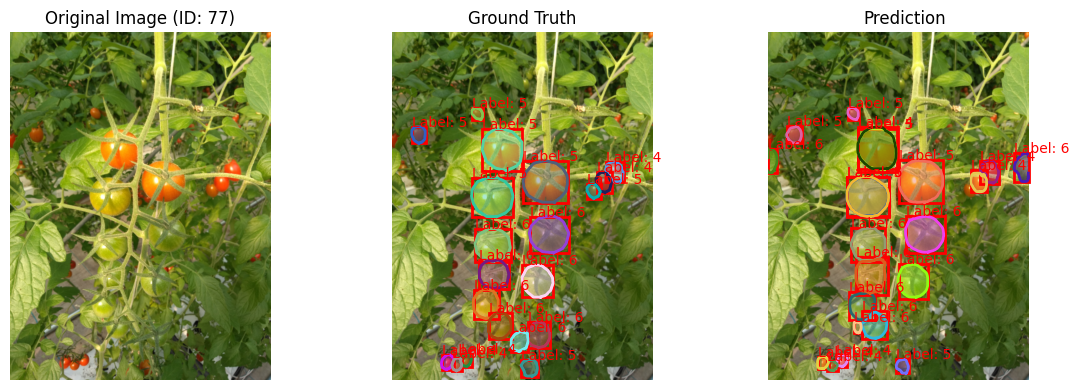

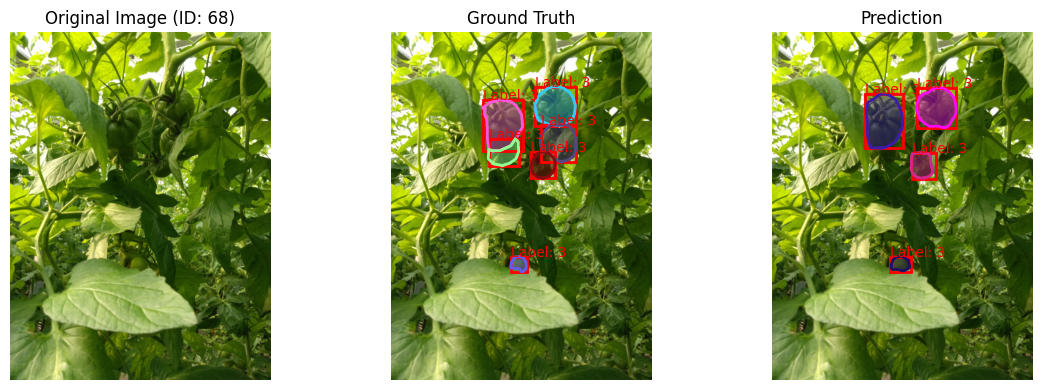

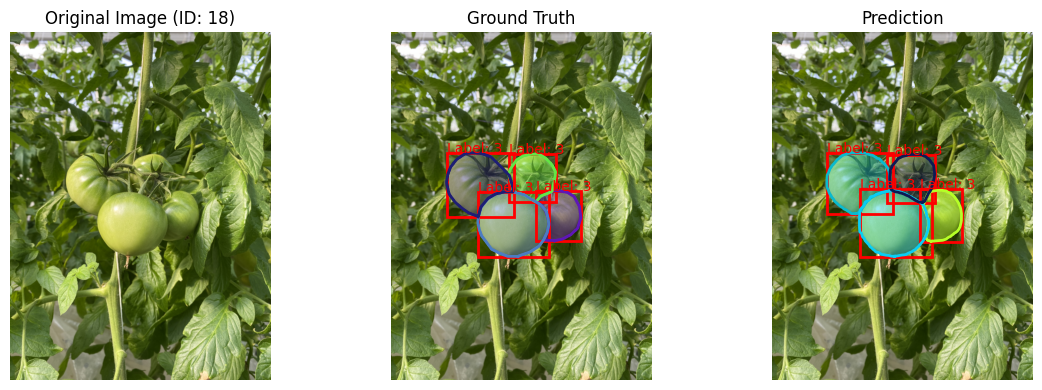

In [74]:
# Plot 10 instances of the model's prediction
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
plot_predictions(laboro_test_dataset, None, model, device, num_instances=3)

## Stage 2: Trait Extraction and Analysis

In [26]:
categories = [
    {
      "id" : 1,
      "maturity" : "fully_ripened_early_girl",
      "supercategory" : "early_girl_tomato"
    },
    {
      "id" : 2,
      "maturity" : "half_ripened_early_girl",
      "supercategory" : "early_girl_tomato"
    },
    {
      "id" : 3,
      "maturity" : "unripe_early_girl",
      "supercategory" : "early_girl_tomato"
    },
    {
      "id" : 4,
      "maturity" : "fully_ripened_cherry",
      "supercategory" : "cherry_tomato"
    },
    {
      "id" : 5,
      "maturity" : "half_ripened_cherry",
      "supercategory" : "cherry_tomato"
    },
    {
      "id" : 6,
      "maturity" : "unripe_cherry",
      "supercategory" : "cherry_tomato"
    }
  ]

# Add 'background' as the first class
CLASSES = ['background']
CLASSES.extend([cat['maturity'] for cat in sorted(categories, key=lambda x: x['id'])])

print(CLASSES)


['background', 'fully_ripened_early_girl', 'half_ripened_early_girl', 'unripe_early_girl', 'fully_ripened_cherry', 'half_ripened_cherry', 'unripe_cherry']


In [35]:
def trait_extraction(predictions, dataset, confidence_threshold=0.5):
    """
    Extract traits from the predictions.

    Args:
    - predictions: List of predictions from the model.
    - ground_truth: List of ground truth labels.

    Returns:
    - results: Dictionary containing counts, maturity index, and evaluation metrics.
    """
    total_detected = sum([1 for pred in predictions for score, label in zip(pred['scores'], pred['labels']) if label.item() in [1,2,3,4,5,6] and score.item() > confidence_threshold])
    fully_ripened = sum([1 for pred in predictions for score, label in zip(pred['scores'], pred['labels']) if label.item() in [1,4] and score.item() > confidence_threshold])
    maturity_index = fully_ripened / total_detected if total_detected else 0

    # Extracting ground truth details
    gt_tomatoes = 0
    gt_fully_ripened = 0
    for _, target in dataset:
        gt_tomatoes += sum(1 for label in target['labels'] if label.item() in [1,2,3,4,5,6])
        gt_fully_ripened += sum(1 for label in target['labels'] if label.item() in [1,4])

    gt_maturity_index = gt_fully_ripened / gt_tomatoes if gt_tomatoes else 0

    mse_maturity = (maturity_index - gt_maturity_index) ** 2
    mse_count = (total_detected - gt_tomatoes) ** 2
    rmse_maturity = np.sqrt(mse_maturity)
    rmse_count = np.sqrt(mse_count)

    results = {
        "Predicted Total Tomatoes": total_detected,
        "Predicted Fully Ripened": fully_ripened,
        "Predicted Maturity Index": maturity_index,
        "Ground Truth Total Tomatoes": gt_tomatoes,
        "Ground Truth Fully Ripened": gt_fully_ripened,
        "Ground Truth Maturity Index": gt_maturity_index,
        "MSE Maturity": mse_maturity,
        "MSE Count": mse_count,
        "RMSE Maturity": rmse_maturity,
        "RMSE Count": rmse_count
    }
    return results


In [34]:
# Assuming you have a list of ground truth labels for your test set
results = trait_extraction(all_predictions, laboro_test_dataset)
for key, value in results.items():
    print(f"{key}: {value}")


Predicted Total Tomatoes: 2036
Predicted Fully Ripened: 350
Predicted Maturity Index: 0.1719056974459725
Ground Truth Total Tomatoes: 1996
Ground Truth Fully Ripened: 341
Ground Truth Maturity Index: 0.17084168336673347
MSE Maturity: 1.1321259608188893e-06
MSE Count: 1600
RMSE Maturity: 0.001064014079239034
RMSE Count: 40.0


In [45]:
def single_trait_extraction(prediction, ground_truth, confidence_threshold=0.5):
    """
    Extract traits from a single prediction.

    Args:
    - prediction: Predicted labels and boxes from the model.
    - ground_truth: Ground truth labels and boxes.

    Returns:
    - results: Dictionary containing counts and maturity index.
    """

    # Filter out predictions below the confidence threshold
    confident_labels = [label.item() for score, label in zip(prediction['scores'], prediction['labels']) if score.item() > confidence_threshold]

    detected_tomatoes = len(confident_labels)
    fully_ripened_tomatoes = sum(1 for label in confident_labels if CLASSES[label] in ['fully_ripened_early_girl', 'fully_ripened_cherry'])
    half_ripened_tomatoes = sum(1 for label in confident_labels if CLASSES[label] in ['half_ripened_early_girl', 'half_ripened_cherry'])
    unripe_tomatoes = sum(1 for label in confident_labels if CLASSES[label] in ['unripe_early_girl', 'unripe_cherry'])

    maturity_index = fully_ripened_tomatoes / detected_tomatoes if detected_tomatoes else 0

    results = {
        'Detected Tomatoes': detected_tomatoes,
        'Fully Ripened Tomatoes': fully_ripened_tomatoes,
        'Half Ripened Tomatoes': half_ripened_tomatoes,
        'Unripe Tomatoes': unripe_tomatoes,
        'Maturity Index': maturity_index
    }

    return results


In [60]:
def traits_from_groundtruth(labels_list):
    """
    Extract traits from a list of labels.
    """
    detected_tomatoes = len(labels_list)
    fully_ripened_tomatoes = sum(1 for label in labels_list if CLASSES[label] in ['fully_ripened_early_girl', 'fully_ripened_cherry'])
    half_ripened_tomatoes = sum(1 for label in labels_list if CLASSES[label] in ['half_ripened_early_girl', 'half_ripened_cherry'])
    unripe_tomatoes = sum(1 for label in labels_list if CLASSES[label] in ['unripe_early_girl', 'unripe_cherry'])

    maturity_index = fully_ripened_tomatoes / detected_tomatoes if detected_tomatoes else 0

    results = {
        'Detected Tomatoes': detected_tomatoes,
        'Fully Ripened Tomatoes': fully_ripened_tomatoes,
        'Half Ripened Tomatoes': half_ripened_tomatoes,
        'Unripe Tomatoes': unripe_tomatoes,
        'Maturity Index': maturity_index
    }
    return results

In [61]:
def plot_prediction_and_traits(image, target, output, image_id=None, confidence_threshold=0.5):
    """
    Plots the original image, ground truth, prediction, and extracted traits.

    Args:
    - image: The image tensor.
    - target: The ground truth data.
    - output: The model's prediction.
    - image_id: ID of the image.
    - confidence_threshold: The confidence threshold to filter predictions.
    """

    # Convert tensors to numpy arrays for plotting
    mask = output['scores'] > confidence_threshold
    output['boxes'] = output['boxes'][mask]
    output['labels'] = output['labels'][mask]
    output['masks'] = output['masks'][mask]

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_np = image.cpu().numpy().transpose((1, 2, 0)) * std + mean
    image_np = np.clip(image_np, 0, 1)

    # Extract traits
    prediction_traits = single_trait_extraction(output, target)
    ground_truth_traits = traits_from_groundtruth(target['labels'].cpu().numpy())

    fig, axs = plt.subplots(1, 5, figsize=(20, 4))

    # Display the image
    title = 'Original Image' if image_id is None else f'Original Image (ID: {image_id})'
    axs[0].imshow(image_np)
    axs[0].set_title(title)

    # Display the ground truth masks with its contour
    axs[1].imshow(image_np)
    axs[1].set_title('Ground Truth')
    for mask in target['masks']:
        mask_np = mask.cpu().numpy()
        contours = measure.find_contours(mask_np, 0.5)
        color = (random.random(), random.random(), random.random())  # Random color for each mask
        for contour in contours:
            axs[1].plot(contour[:, 1], contour[:, 0], linewidth=2, color=color)
            axs[1].fill(contour[:, 1], contour[:, 0], color=color, alpha=0.4)
    for box, label in zip(target['boxes'], target['labels']):
        box = box.cpu()  # Move the tensor to CPU
        rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor='r', facecolor='none')
        axs[1].add_patch(rect)
        axs[1].text(box[0], box[1], f'Label: {label.item()}', color='r')

    # Display the ground truth traits
    gt_trait_strings = [f"{key}: {value}" for key, value in ground_truth_traits.items()]
    gt_trait_text = "\n".join(gt_trait_strings)
    axs[2].text(0.5, 0.5, gt_trait_text, ha='center', va='center', transform=axs[2].transAxes)
    axs[2].axis('off')
    axs[2].set_title('Ground Truth Traits')

    # Display the predicted masks with its contour
    axs[3].imshow(image_np)
    axs[3].set_title('Prediction')
    for mask in output['masks']:
        mask_np = mask[0, :, :].detach().cpu().numpy()
        contours = measure.find_contours(mask_np, 0.5)
        color = (random.random(), random.random(), random.random())  # Random color for each mask
        for contour in contours:
            axs[3].plot(contour[:, 1], contour[:, 0], linewidth=2, color=color)
            axs[3].fill(contour[:, 1], contour[:, 0], color=color, alpha=0.4)
    for box, label in zip(output['boxes'], output['labels']):
        box = box.cpu()  # Move the tensor to CPU
        rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor='r', facecolor='none')
        axs[3].add_patch(rect)
        axs[3].text(box[0], box[1], f'Label: {label.item()}', color='r')

    # Display the traits
    trait_strings = [f"{key}: {value}" for key, value in prediction_traits.items()]
    trait_text = "\n".join(trait_strings)
    axs[4].text(0.5, 0.5, trait_text, ha='center', va='center', transform=axs[4].transAxes)
    axs[4].axis('off')
    axs[4].set_title('Extracted Traits')

    # Remove axis
    for i in range(4):
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

In [62]:
def plot_trait_predictions(dataset, idxs, model, device, num_instances=10):
    # Choose random instances if idxs is not provided
    if idxs is None:
        idxs = random.sample(range(len(dataset)), num_instances)
    for i in idxs:
        img, target = dataset[i]
        img = img.to(device)
        target = {k: v.to(device) for k, v in target.items()}
        with torch.no_grad():
            prediction = model([img])
        # Display the image, ground truth, prediction, and traits
        plot_prediction_and_traits(img.cpu(), target, prediction[0], image_id=i)


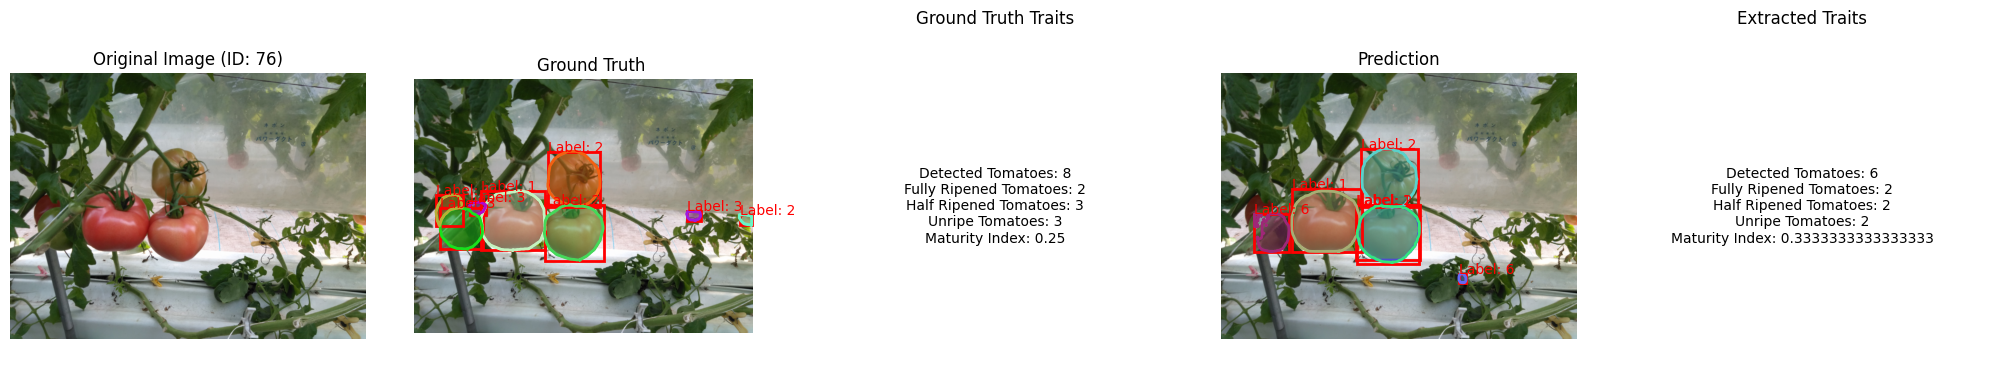

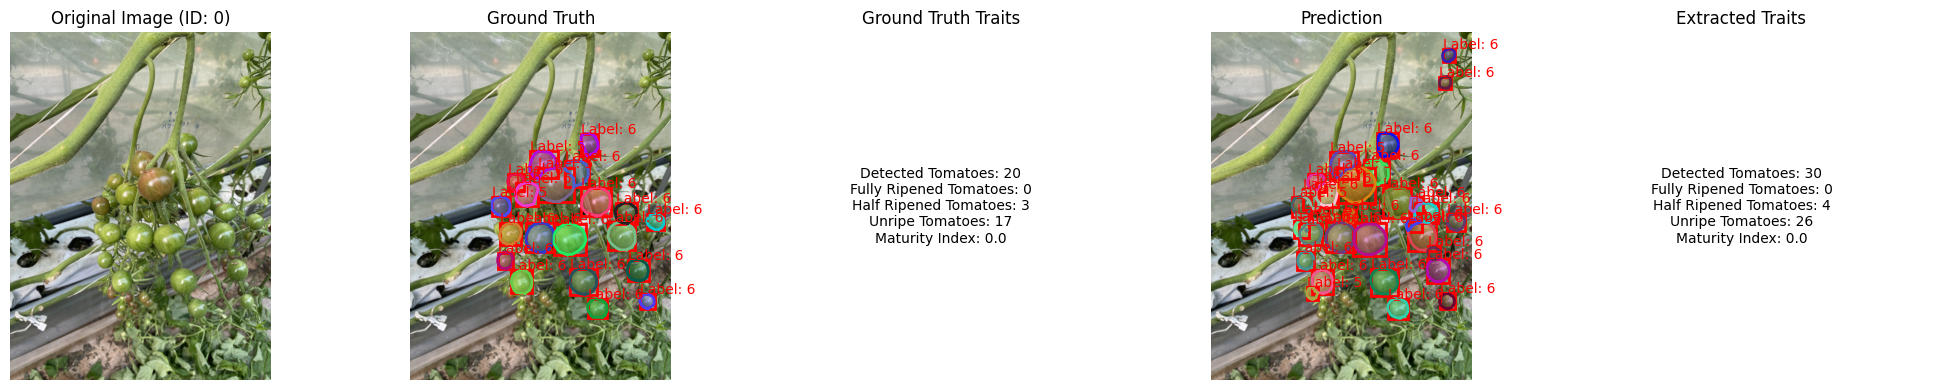

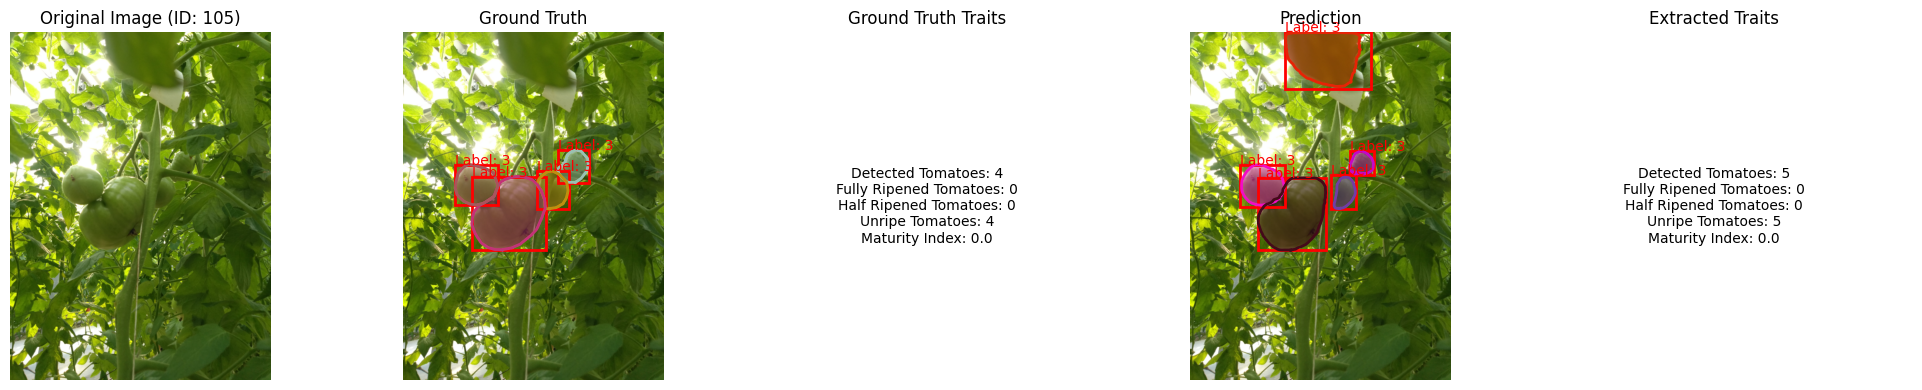

In [65]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
plot_trait_predictions(laboro_test_dataset, None, model, device, num_instances=3)